## Notebook to determine ROIs for overlapping cells in 3d spot-based transcriptomics data

In [5]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Basic imports:

In [6]:
import os
# from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.neighbors import NearestNeighbors
import anndata


#### Define parameters

In [7]:
# SSAM vector field resolution:
um_per_pixel = 2.5

# SSAM pandwidth:
bw = 1

# KNN diffusion iterations to move spots to z-axis zero mean:
z_centralization_iters = 20

# {0:'xenium_mouse_brain',1:'merfish_mouse_brain',2:'merfish_liver'}
dataset =0

file_root = '/dh-projects/ag-ishaque/analysis/tiesmeys/spot-data-z-axis-incoherence/src'


## Define & load data

####  0: Xenium Mouse brain dataset:

In [8]:

if dataset == 0:

    spot_df_raw = pd.read_csv('/dh-projects/ag-ishaque/analysis/tiesmeys/data/zenodo/MERFISH/raw_data/merfish_barcodes_example.csv', usecols=['Gene_name', 'Centroid_X', 'Centroid_Y', 'Centroid_Z'],)
    spot_df_raw.columns = ['gene','x','y','z']



    # Remove 'blank' genes:
    spot_df_raw = spot_df_raw[~spot_df_raw.gene.str.contains('Blank')][::1]

    spot_df_raw['gene']=spot_df_raw['gene'].astype('category')

    # spot_df = spot_df_raw.copy()
    genes = sorted(spot_df_raw.gene.unique())


spot_df_raw.x-=spot_df_raw.x.min()
spot_df_raw.y-=spot_df_raw.y.min()

spot_df_raw.x/=um_per_pixel
spot_df_raw.y/=um_per_pixel




In [9]:
from src import ovrlp

roi_df = ovrlp.find_overlaps(spot_df_raw,min_distance=20)
# _=ovrlp.assign_xy(spot_df_raw)
roi_df

x    y  divergence
0      0  494   76.959403
1      0  536   76.687463
2      1  673   71.948211
3      5  528   75.957200
4      7  324   69.222651
..   ...  ...         ...
235  710  356   94.442220
236  714   85   75.764499
237  715    4   80.595888
238  719   52  110.450878
239  719  528   69.495089

[240 rows x 3 columns]

#### Load snRNAseq data for cell typing:

In [10]:
import gzip

scrna_genes = []

with gzip.open(os.path.join(file_root,"../../data/zenodo/MERFISH/raw_data/GSE113576_genes.tsv.gz "), "rt") as f:
    for line in f:
        ensid, gene = line.rstrip().split('\t')
        # Correct gene name
        if gene == '4732456N10Rik':
            gene = "Krt90"
        scrna_genes.append(gene)

scrna_barcodes = []
with gzip.open(os.path.join(file_root,"../../data/zenodo/MERFISH/raw_data/GSE113576_barcodes.tsv.gz"), "rt") as f:
    for line in f:
        scrna_barcodes.append(line.rstrip())

from scipy.io import mmread
with gzip.open(os.path.join(file_root,"../../data/zenodo/MERFISH/raw_data/GSE113576_matrix.mtx.gz")) as f:
    scrna_expmat = mmread(f)

import scanpy as sc
import anndata

adata_scrna = anndata.AnnData(X=scrna_expmat.T, obs={'barcode': scrna_barcodes}, var={'gene': scrna_genes})
adata_scrna.obs.index = adata_scrna.obs.index.astype(int)

adata_scrna.X = np.array(np.nan_to_num(adata_scrna.X).todense()).squeeze()

scrna_cluster_dic = {}
scrna_cluster_dic2 = {}

# Downloaded from supp. material of Moffit et al, table S1
# This file contains cluster metadata
table_s1_df = pd.read_csv(os.path.join(file_root, 
            "../../data/zenodo/MERFISH/raw_data/aau5324_moffitt_table-s1.csv"), on_bad_lines='skip', )
table_s1_df = table_s1_df.fillna('')
adata_scrna.obs['cluster_1'] = ''
adata_scrna.obs['cluster_2'] = ''

n=0

for i, (bc, _, _, c1, c2, c3) in table_s1_df.iterrows():
    if c2 == '' and c3 == '':
        c2 = c1 # Ambiguous and Unstable
    elif c2 == '':
        c2 = c1 + ' (' + c3 + ')'
        
    adata_scrna.obs.loc[n,'cluster_1'] = c1
    adata_scrna.obs.loc[n,'cluster_2'] = c2
    
    scrna_cluster_dic[bc] = c1
    scrna_cluster_dic2[bc] = c2

    n+=1

celltypes = sorted(adata_scrna.obs.cluster_1.unique())
signatures = pd.DataFrame(index=genes,columns=celltypes)

# fill the signatures with mean expression values:
for celltype in signatures.columns:
    subset = adata_scrna.X[adata_scrna.obs.cluster_1==celltype]
    subset = pd.Series(np.nan_to_num(subset).mean(0),
                       index=adata_scrna.var.gene.values)

    signatures[celltype] = subset[genes].values / (subset.sum()+1)



/tmp/ipykernel_1515597/2183177607.py:25: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_scrna = anndata.AnnData(X=scrna_expmat.T, obs={'barcode': scrna_barcodes}, var={'gene': scrna_genes})


[1 4 4 ... 7 7 9]
Plotting case 0


/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Plotting case 1
Plotting case 2
Plotting case 3
Plotting case 4


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


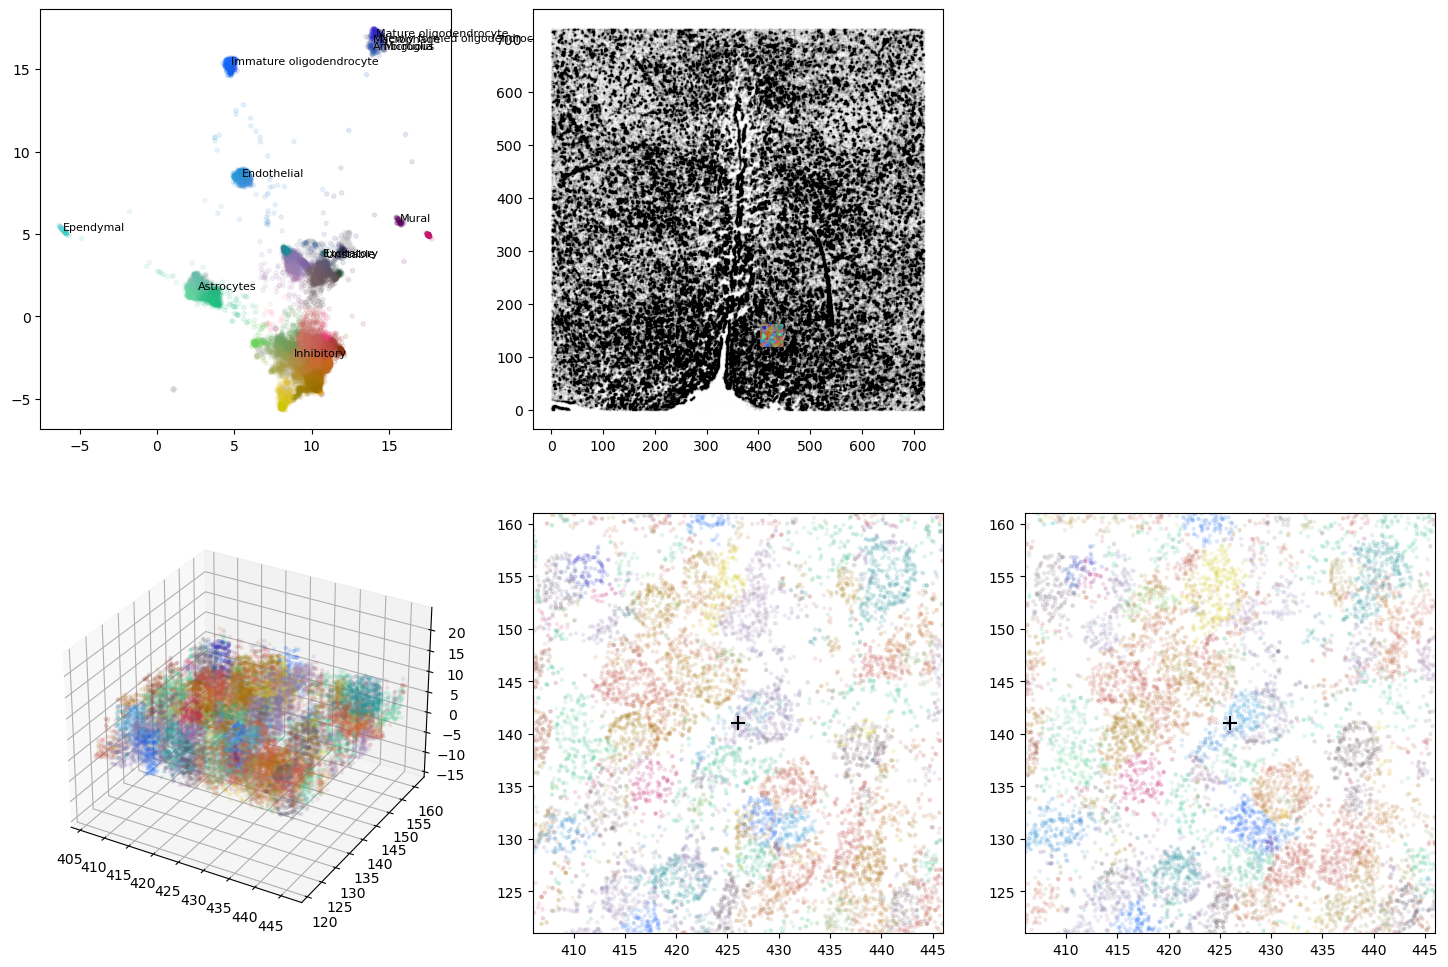

posx and posy should be finite values
posx and posy should be finite values


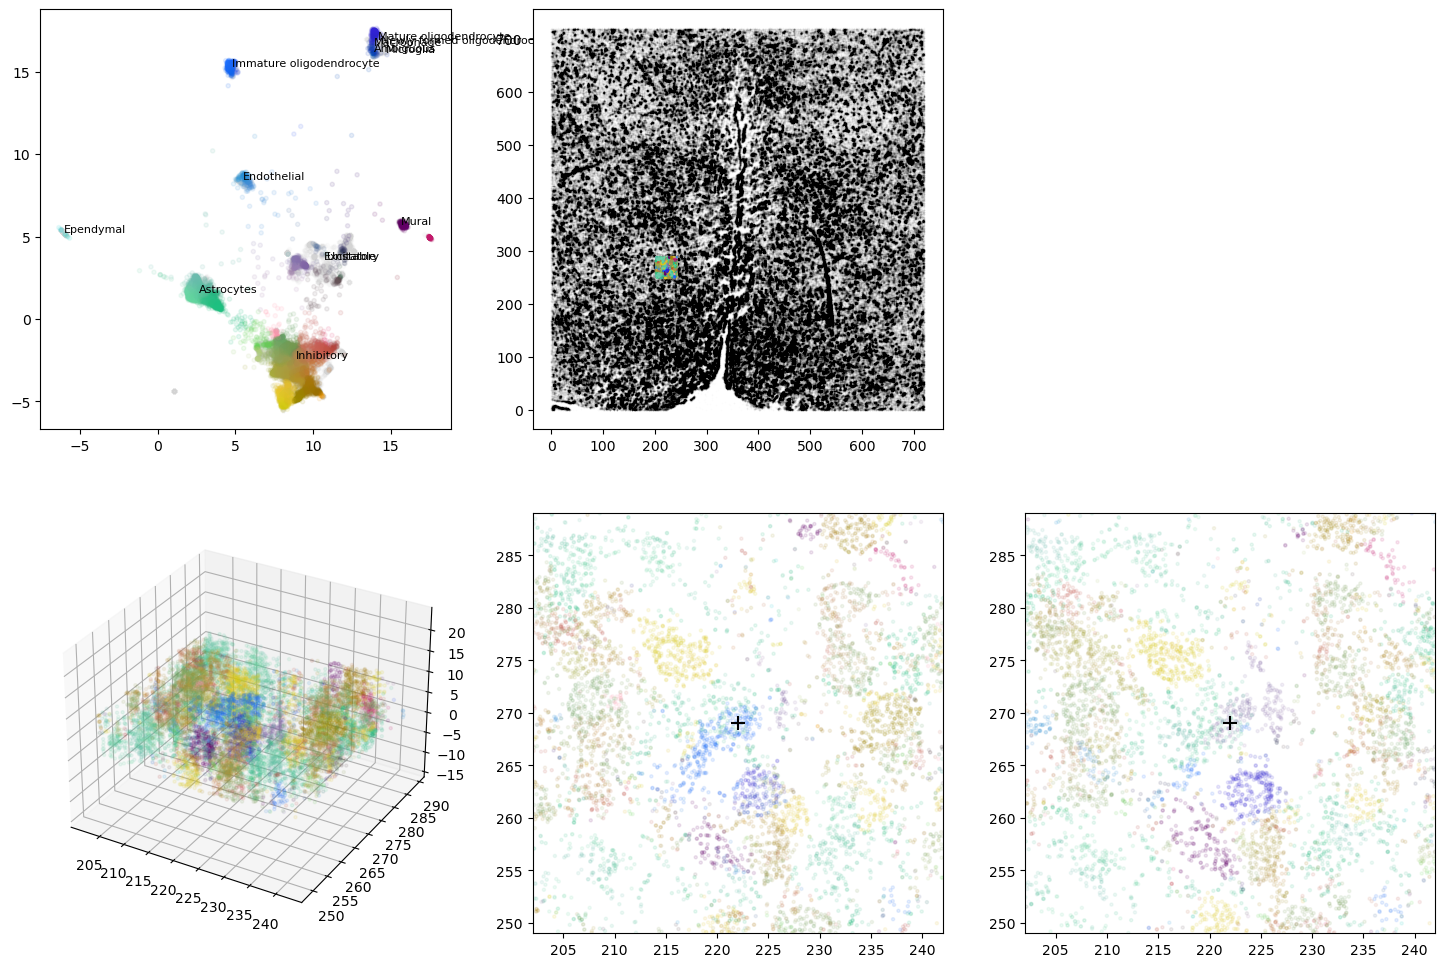

posx and posy should be finite values
posx and posy should be finite values


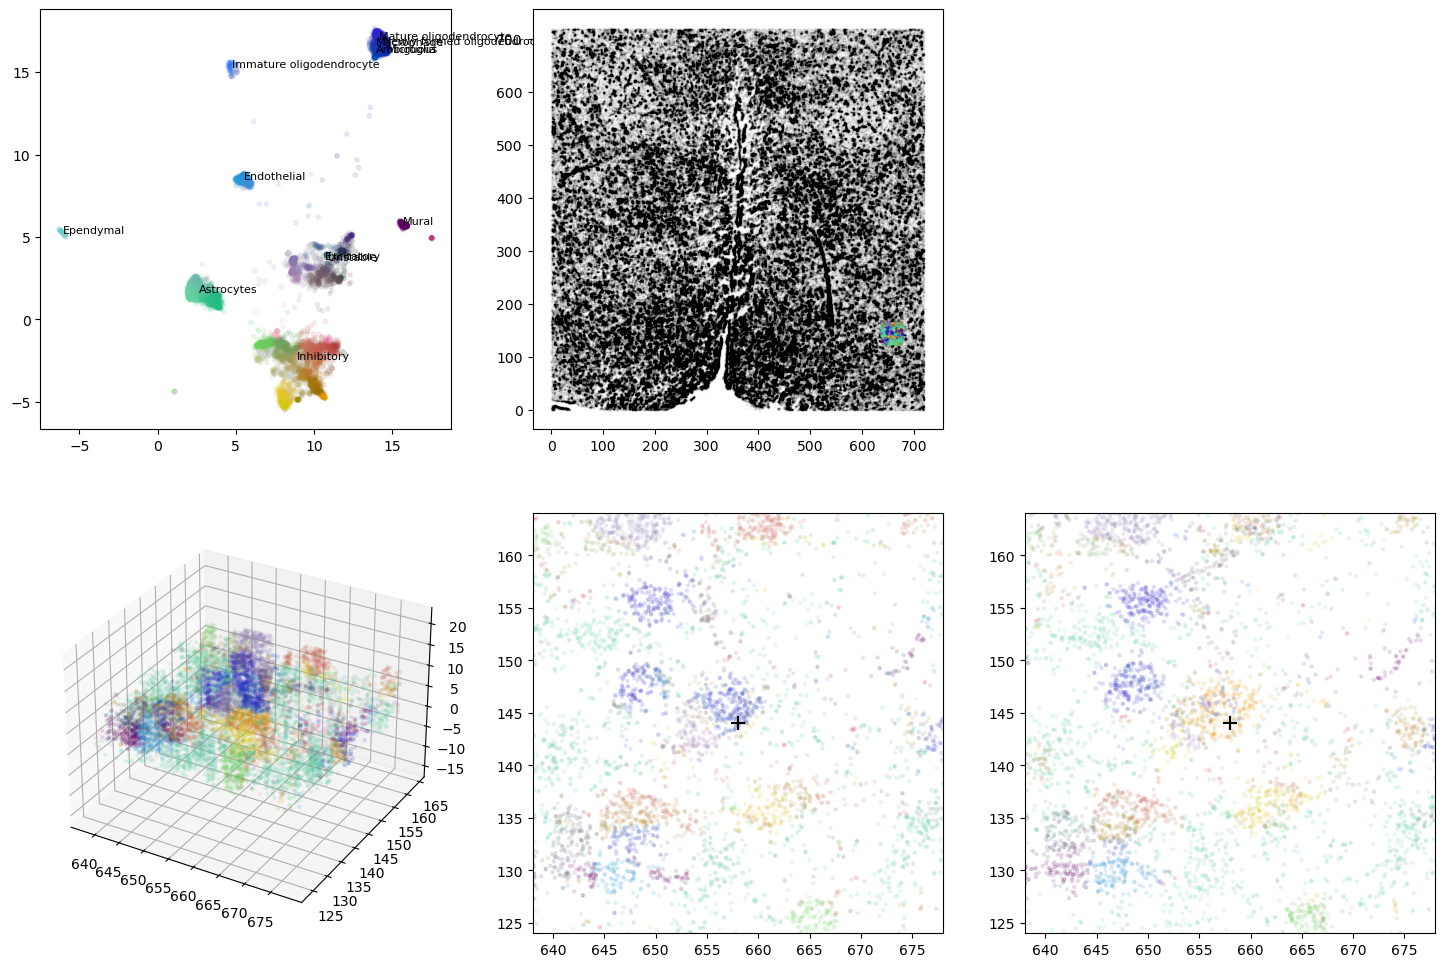

posx and posy should be finite values
posx and posy should be finite values


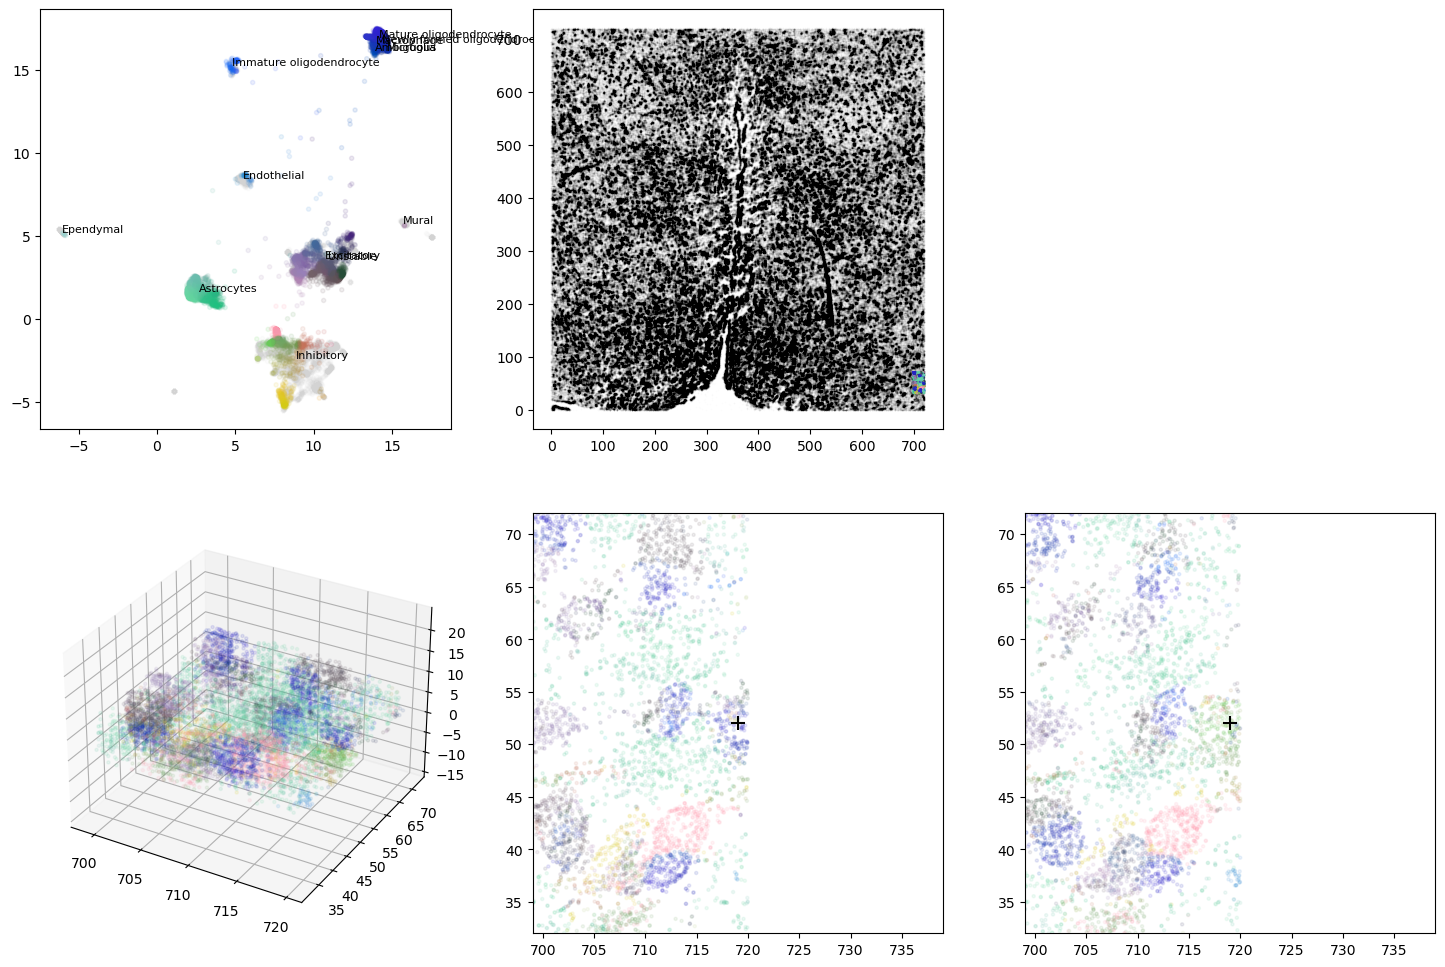

posx and posy should be finite values
posx and posy should be finite values


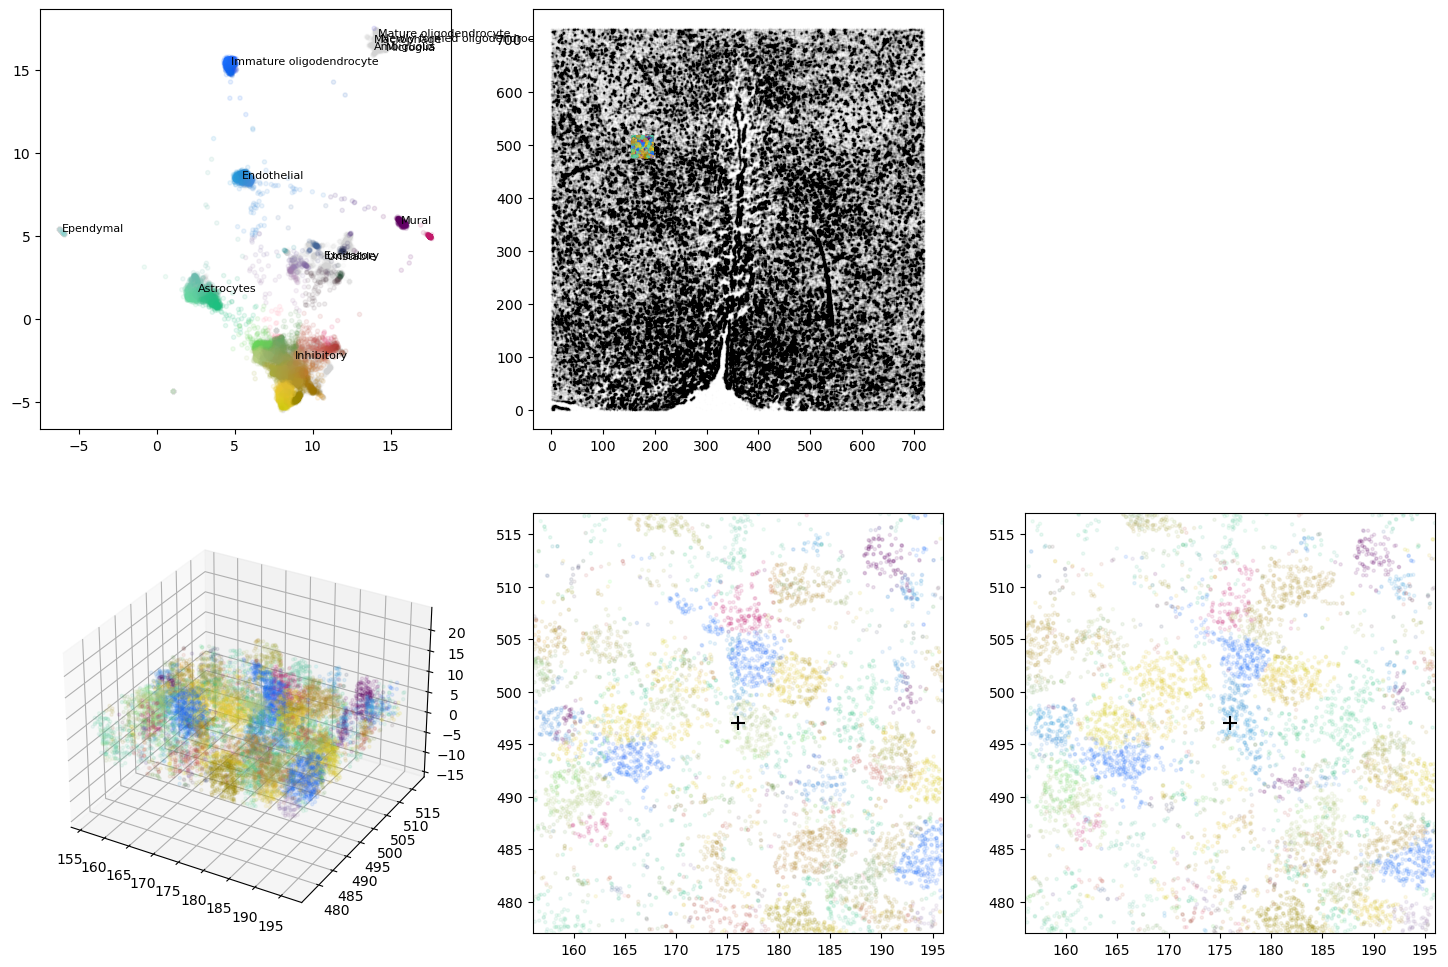

In [18]:

ovrlp.visualize_rois(spot_df_raw,roi_df, signature_matrix=signatures,
                     celltyping_min_expression=5,
                     n_cases=[0,1,2,3,4]+list(range(5,5,5)),plot_window_size=20)

In [19]:
expressions_top = ovrlp.get_expression_vectors_at_rois(df = spot_df_raw[spot_df_raw.z>spot_df_raw.z_delim], rois_x=roi_df.x,
                                        rois_y=roi_df.y,genes=genes)

expressions_bottom = ovrlp.get_expression_vectors_at_rois(df = spot_df_raw[spot_df_raw.z<spot_df_raw.z_delim], rois_x=roi_df.x,
                                        rois_y=roi_df.y,genes=genes)

                                        



In [20]:
celltype_labels_top = ovrlp.determine_celltype_class_assignments(expressions_top,signatures)
celltype_labels_bottom = ovrlp.determine_celltype_class_assignments(expressions_bottom,signatures)

In [31]:
top_bottom_heatmap = np.zeros((len(signatures.columns),len(signatures.columns)))

for i in range(len(celltype_labels_top)):
    top_bottom_heatmap[celltype_labels_top[i],celltype_labels_bottom[i]]+=1#roi_df.divergence[i]
    top_bottom_heatmap[celltype_labels_bottom[i],celltype_labels_top[i]]+=1#roi_df.divergence[i]

plt.figure(figsize=(10,10))
plt.imshow(top_bottom_heatmap)
plt.xticks(range(len(signatures.columns)),signatures.columns,rotation=90)
plt.yticks(range(len(signatures.columns)),signatures.columns)

''

''

In [21]:
combined_celltype_labels = []

for i in range(len(celltype_labels_top)):
    ct_str = '-'.join(sorted([signatures.columns[celltype_labels_top[i]],signatures.columns[celltype_labels_bottom[i]]]))
    combined_celltype_labels.append(ct_str)

print(combined_celltype_labels)


['Inhibitory-Inhibitory', 'Ambiguous-Inhibitory', 'Endothelial-Excitatory', 'Ambiguous-Mature oligodendrocyte', 'Excitatory-Microglia', 'Astrocytes-Excitatory', 'Astrocytes-Mural', 'Astrocytes-Astrocytes', 'Excitatory-Immature oligodendrocyte', 'Astrocytes-Excitatory', 'Inhibitory-Microglia', 'Astrocytes-Inhibitory', 'Astrocytes-Inhibitory', 'Endothelial-Excitatory', 'Excitatory-Excitatory', 'Excitatory-Inhibitory', 'Astrocytes-Excitatory', 'Astrocytes-Excitatory', 'Inhibitory-Inhibitory', 'Excitatory-Excitatory', 'Astrocytes-Inhibitory', 'Astrocytes-Inhibitory', 'Endothelial-Inhibitory', 'Endothelial-Inhibitory', 'Astrocytes-Newly formed oligodendrocyte', 'Astrocytes-Excitatory', 'Astrocytes-Inhibitory', 'Inhibitory-Newly formed oligodendrocyte', 'Immature oligodendrocyte-Inhibitory', 'Inhibitory-Microglia', 'Mural-Mural', 'Inhibitory-Mural', 'Inhibitory-Mature oligodendrocyte', 'Astrocytes-Excitatory', 'Astrocytes-Astrocytes', 'Inhibitory-Inhibitory', 'Inhibitory-Inhibitory', 'Astroc

In [22]:
combinations,inverse,counts = np.unique(combined_celltype_labels,return_counts=True,return_inverse=True)

''

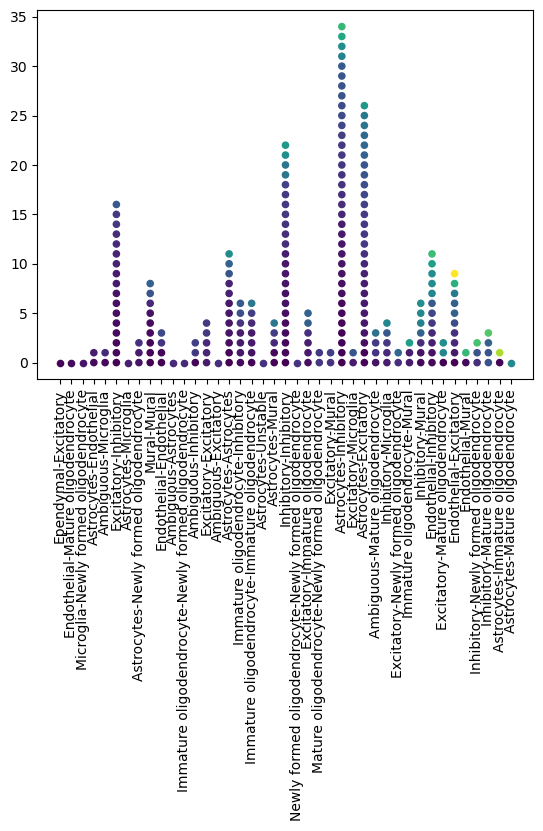

In [26]:
graphs = [[] for i in range(len(counts))]


for i in range(len(roi_df)):
    graphs[inverse[i]].append((roi_df.divergence[i]-roi_df.divergence.min())/(roi_df.divergence.max()-roi_df.divergence.min()))
                                                            
for i in range(len(counts)):
    graphs[i] = sorted(graphs[i])

graphs_idcs = np.argsort([np.mean(l) for l in graphs])

for i in range(len(counts)):
    plt.scatter(np.ones(len(graphs[graphs_idcs[i]]))*i,
                np.arange(len(graphs[graphs_idcs[i]])),c=graphs[graphs_idcs[i]],cmap='viridis',s=20,
                vmin=0,vmax=1)

plt.xticks(np.arange(len(counts)),combinations[graphs_idcs],rotation=90)
''

array([20, 18, 38,  6,  4, 23, 11, 13, 39, 15,  0, 31,  2, 21,  1,  5, 29,
       28, 14, 12, 32, 40, 22, 37, 26,  9, 25,  7,  3, 34, 27, 30, 35, 17,
       24, 16, 19, 36, 33,  8, 10])